<a href="https://colab.research.google.com/github/Sanmay-Das/Smart-Product-Pricing-and-Stock-Prediction-for-E-Commerce/blob/main/Smart_Product_Pricing_and_Stock_Prediction_for_E_Commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries for Spark, data processing, and machine learning
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, unix_timestamp, year, month, isnan, when, count, mean
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, Imputer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [3]:
# Initialize a Spark session for the project
spark = SparkSession.builder.appName("BigBasket Analysis").getOrCreate()

In [4]:
# Load the dataset into a Spark DataFrame
file_path = '/content/BigBasket_Data_Set_Expanded.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [5]:
# Display the structure and sample data of the DataFrame
print("Initial Schema:")
df.printSchema()
print("Initial Row Count:", df.count())
initial_row_count=df.count()
df.show(5)

Initial Schema:
root
 |-- index: string (nullable = true)
 |-- product: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- present_sale_price: double (nullable = true)
 |-- market_price: string (nullable = true)
 |-- type: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- Demand_Index: double (nullable = true)
 |-- Sale_Price_Last_Year: double (nullable = true)
 |-- Sale_Price_Two_Years_Ago: double (nullable = true)

Initial Row Count: 1000070
+-----+--------------------+--------------------+--------------------+-----------------+------------------+------------+--------------------+------+------------+--------------------+------------------------+
|index|             product|            category|        sub_category|            brand|present_sale_price|market_price|                type|rating|Demand_Index|Sale_Price_Last_Year|Sale_Price_Two_Years_Ago|
+-----+-----------

**Exploratory Data Analysis (EDA)**

---



In [6]:
# Get summary statistics for key numerical columns
print("Summary Statistics:")
df.describe(["present_sale_price", "market_price", "rating", "Demand_Index", "Sale_Price_Last_Year", "Sale_Price_Two_Years_Ago"]).show()

Summary Statistics:
+-------+------------------+------------------+------------------+------------------+--------------------+------------------------+
|summary|present_sale_price|      market_price|            rating|      Demand_Index|Sale_Price_Last_Year|Sale_Price_Two_Years_Ago|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------------+
|  count|           1000000|           1000000|            687412|           1000000|             1000000|                  999930|
|   mean| 322.7463495600046|382.14882261758146| 3.948838396769899|   50.523175117617|  290.49185929643824|       274.3409146791595|
| stddev|487.27784065839353| 581.9740643155229|0.9517419969730815|28.926567538894542|  439.02939696461834|       414.5845156418246|
|    min|              2.45|              10.0|               1.0|               1.0|         2.095807268|             1.962495251|
|    max|           12500.0|  Meats & Sausages|         

In [7]:
# Count missing values for all columns
print("Missing Values Count:")
null_counts = df.select([(col(c).isNull().cast("int")).alias(c) for c in df.columns]).groupBy().sum()
null_counts.show()

Missing Values Count:
+----------+------------+-------------+-----------------+----------+-----------------------+-----------------+---------+-----------+-----------------+-------------------------+-----------------------------+
|sum(index)|sum(product)|sum(category)|sum(sub_category)|sum(brand)|sum(present_sale_price)|sum(market_price)|sum(type)|sum(rating)|sum(Demand_Index)|sum(Sale_Price_Last_Year)|sum(Sale_Price_Two_Years_Ago)|
+----------+------------+-------------+-----------------+----------+-----------------------+-----------------+---------+-----------+-----------------+-------------------------+-----------------------------+
|         0|          41|           70|               70|       103|                     70|               70|      105|     312658|               70|                       70|                          140|
+----------+------------+-------------+-----------------+----------+-----------------------+-----------------+---------+-----------+-----------------+

In [8]:
# Count unique products
distinct_products = df.select("product").distinct().count()
print(f"Number of unique products: {distinct_products}")

Number of unique products: 23543


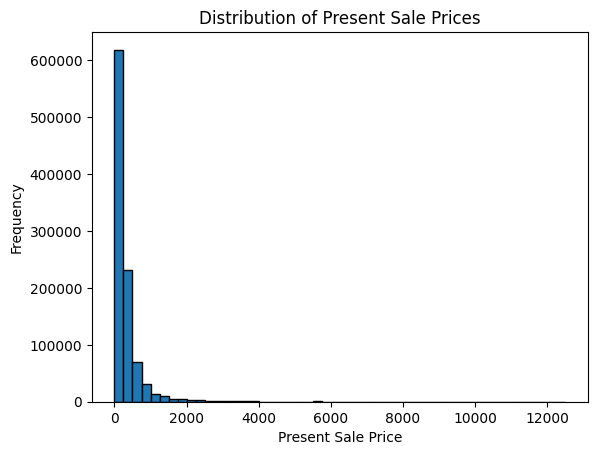

In [9]:
# Plot the distribution of present sale prices
present_prices = df.select("present_sale_price").filter(col("present_sale_price").isNotNull()).rdd.flatMap(lambda x: x).collect()
plt.hist(present_prices, bins=50, edgecolor='black')
plt.title("Distribution of Present Sale Prices")
plt.xlabel("Present Sale Price")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Display top 10 most expensive products
print("Top 10 Most Expensive Products:")
df.select("product", "present_sale_price").distinct().orderBy(col("present_sale_price").desc()).show(10)

Top 10 Most Expensive Products:
+--------------------+------------------+
|             product|present_sale_price|
+--------------------+------------------+
|     Bravura Clipper|           12500.0|
|Pet Food - N&D Te...|           10090.0|
|Epilator SE9-9961...|           8184.44|
|Gas Stove-4 Burne...|            7999.0|
|Extra Virgin Oliv...|            7299.0|
|4 Burner Gas Stov...|            7270.0|
|Gas Stove-3 Burne...|            6999.0|
| Whey Protein Powder|            6700.0|
|Good Girl Eau De ...|            6660.0|
|Olive Oil - Extra...|            6500.0|
+--------------------+------------------+
only showing top 10 rows



In [13]:
# Clean the DataFrame by handling null values and duplicate rows
threshold = int(0.2 * len(df.columns))  # Allow rows with at most 20% null values
df = df.dropna(thresh=threshold).dropDuplicates()
cleaned_row_count = df.count()

In [14]:
# Ensure numerical columns have the correct data type
for col_name in ["Demand_Index", "present_sale_price", "market_price", "Sale_Price_Last_Year", "Sale_Price_Two_Years_Ago"]:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))

In [15]:
print("Cleaned Schema:")
df.printSchema()
print("Cleaned Row Count:", df.count())
df.show(5)

Cleaned Schema:
root
 |-- index: string (nullable = true)
 |-- product: string (nullable = true)
 |-- category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- present_sale_price: double (nullable = true)
 |-- market_price: double (nullable = true)
 |-- type: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- Demand_Index: double (nullable = true)
 |-- Sale_Price_Last_Year: double (nullable = true)
 |-- Sale_Price_Two_Years_Ago: double (nullable = true)

Cleaned Row Count: 500002
+-----+--------------------+--------------------+--------------------+-------------+------------------+------------+--------------------+------+------------+--------------------+------------------------+
|index|             product|            category|        sub_category|        brand|present_sale_price|market_price|                type|rating|Demand_Index|Sale_Price_Last_Year|Sale_Price_Two_Years_Ago|
+-----+--------------------

In [16]:
rows_dropped_percentage = ((initial_row_count - cleaned_row_count) / initial_row_count) * 100
print(f"Percentage of Unusable Data Removed: {rows_dropped_percentage:.2f}%")

Percentage of Unusable Data Removed: 50.00%


In [18]:
# Analyze most demanded products
most_demanded = df.groupBy("product").avg("Demand_Index").withColumnRenamed("avg(Demand_Index)", "average_demand")
most_demanded = most_demanded.filter(col("average_demand") <= 100).orderBy(col("average_demand").desc())
print("Most Demanded Products:")
most_demanded.show(50)

Most Demanded Products:
+--------------------+-----------------+
|             product|   average_demand|
+--------------------+-----------------+
|Durum Wheat Pasta...|74.44444444444444|
|Jowar & Sweet Pot...|             74.0|
|Total 10 Activ Na...|73.72222222222223|
|Fresho Meat Mutto...|73.27777777777777|
|Refreshing Intima...|73.16666666666667|
|        Starch Spray|72.33333333333333|
|        Triple Layer|72.22222222222223|
|Insulated Stainle...|72.11111111111111|
|Sweet Chilli Tort...|71.88888888888889|
|Homemade Red Chil...|71.88888888888889|
|Tablet - Organic,...|71.78947368421052|
|     Creamy Milk Bar|71.72222222222223|
|         Fish Masala| 71.6842105263158|
|De-Toxification H...|             71.5|
|Steel Storage/Lun...|71.42105263157895|
|Spa Bath Shower F...|71.38888888888889|
|Idly Stand - Non ...|71.33333333333333|
|Parama - Luxury B...|71.27777777777777|
|      Celery Bitters|71.16666666666667|
|       Chicken - Ham|71.11111111111111|
|Hand Beater - Gan...|70.94444444

**Machine Learning Workflow**

---



In [19]:
# Add an index column to preserve order
data = df.withColumn("csv_order", col("index").cast("integer"))

In [20]:
# Impute missing values with mean for selected columns
columns_to_impute = ["Sale_Price_Last_Year", "Sale_Price_Two_Years_Ago", "Demand_Index", "rating"]
for column in columns_to_impute:
    mean_value = data.selectExpr(f"mean({column}) as mean_{column}").collect()[0][0]
    data = data.fillna({column: mean_value})

In [22]:
# Prepare features using VectorAssembler
assembler = VectorAssembler(inputCols=["Sale_Price_Last_Year", "Sale_Price_Two_Years_Ago", "Demand_Index", "rating"], outputCol="features_unscaled")
data = assembler.transform(data)

In [23]:
# Scale features to a uniform range
scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features")
data = scaler.fit(data).transform(data)

In [24]:
# Prepare the dataset for training
ml_data = data.select("csv_order", "product", "features", "Sale_Price_Last_Year", "Sale_Price_Two_Years_Ago", "present_sale_price").filter(col("present_sale_price").isNotNull()).dropDuplicates(["csv_order"])
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

In [25]:
# Train a Decision Tree Regressor model
dt = DecisionTreeRegressor(featuresCol="features", labelCol="present_sale_price")
dt_model = dt.fit(train_data)

In [26]:
# Generate predictions and evaluate the model
dt_predictions = dt_model.transform(ml_data).withColumnRenamed("prediction", "DT_Prediction")
final_predictions = ml_data.join(dt_predictions.select("csv_order", "DT_Prediction"), on="csv_order").select("csv_order", "product", "Sale_Price_Last_Year", "Sale_Price_Two_Years_Ago", "present_sale_price", "DT_Prediction").orderBy("csv_order")
final_predictions.show(30)

+---------+--------------------+--------------------+------------------------+------------------+------------------+
|csv_order|             product|Sale_Price_Last_Year|Sale_Price_Two_Years_Ago|present_sale_price|     DT_Prediction|
+---------+--------------------+--------------------+------------------------+------------------+------------------+
|        1|Garlic Oil - Vege...|          208.838858|             182.1169558|             220.0|231.06843461351477|
|        2|Water Bottle - Or...|         167.1146439|             156.5084953|             180.0|177.73138524897038|
|        3|Brass Angle Deep ...|         104.9170125|             104.9988039|             119.0|128.34702020202022|
|        4|Cereal Flip Lid C...|         139.1185068|             130.3123435|             149.0|177.73138524897038|
|        5|Creme Soft Soap -...|         147.5120411|             135.3195431|             162.0|177.73138524897038|
|        6|Germ - Removal Mu...|         150.8431804|           

In [27]:
# Calculate the 90th percentile for price and demand
price_percentile_90 = df.approxQuantile("present_sale_price", [0.9], 0.01)[0]
demand_percentile_90 = df.approxQuantile("Demand_Index", [0.9], 0.01)[0]

print(f"90th Percentile of Present Sale Price: {price_percentile_90}")
print(f"90th Percentile of Demand Index: {demand_percentile_90}")


90th Percentile of Present Sale Price: 639.0
90th Percentile of Demand Index: 90.0


In [28]:
# Filter products in the top 10% for price and demand
top_10_percent_products = df.filter(
    (col("present_sale_price") >= price_percentile_90) |
    (col("Demand_Index") >= demand_percentile_90)
)

# Display the results
print("Top 10% Most Expensive and Most Demanded Products:")
top_10_percent_products.select("product", "present_sale_price", "Demand_Index").show(20)


Top 10% Most Expensive and Most Demanded Products:
+--------------------+------------------+------------+
|             product|present_sale_price|Demand_Index|
+--------------------+------------------+------------+
|Herbal Aloevera N...|             215.0|        90.0|
|Copper Hammered D...|            1899.0|        36.0|
|     Mix - Rava Dosa|             110.0|        97.0|
|Plastic Pro Lock ...|             179.0|        91.0|
|Touch 'N' Fresh F...|              85.0|        92.0|
|Ylang Ylang Essen...|             351.0|        97.0|
|100% Melamine Idl...|             149.0|        99.0|
|Cooling Mint Body...|             144.0|        93.0|
|            Glycerin|              75.0|        98.0|
|Face wash - Anti ...|              59.5|        98.0|
|Chai/Cup & Saucer...|             979.0|        20.0|
|Dahnul Oudh Bakha...|            1840.0|        76.0|
|Moroccan Argan Ha...|             699.0|        73.0|
|LED Lamp - 10 Wat...|             195.0|        91.0|
|Color N Care 

In [29]:
total_products = df.select("product").distinct().count()
top_10_products_count = top_10_percent_products.select("product").distinct().count()

print(f"Total Products: {total_products}")
print(f"Products in Top 10%: {top_10_products_count}")
percentage = (top_10_products_count / total_products) * 100
print(f"Percentage of Products in Top 10%: {percentage:.2f}%")


Total Products: 23543
Products in Top 10%: 21296
Percentage of Products in Top 10%: 90.46%


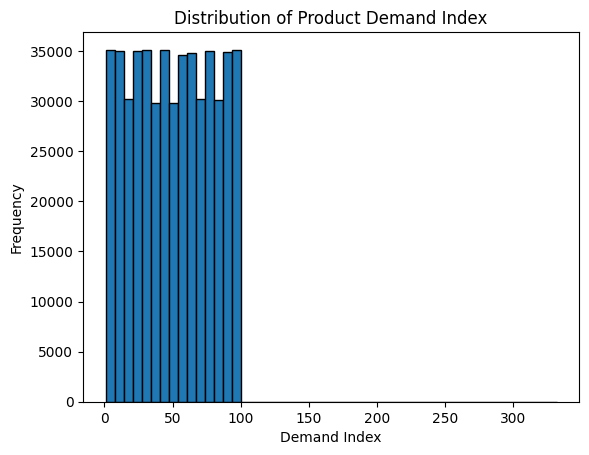

In [30]:
# Extract Demand Index for non-null values
demand_index = df.select("Demand_Index").filter(col("Demand_Index").isNotNull()).rdd.flatMap(lambda x: x).collect()

# Plot the distribution of Demand Index
plt.hist(demand_index, bins=50, edgecolor='black')
plt.title("Distribution of Product Demand Index")
plt.xlabel("Demand Index")
plt.ylabel("Frequency")
plt.show()


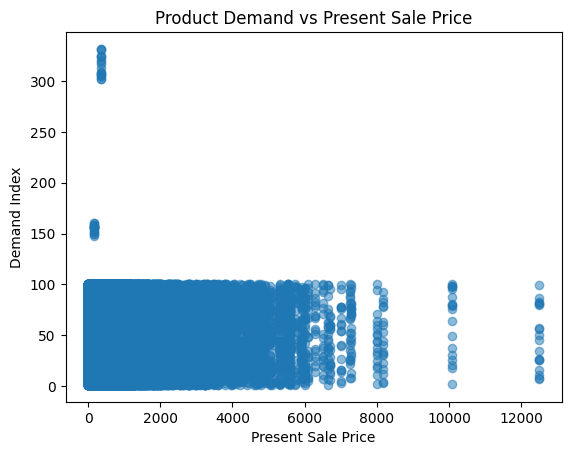

In [31]:
# Extract Present Sale Price and Demand Index
price_demand_data = df.select("present_sale_price", "Demand_Index").filter(
    col("present_sale_price").isNotNull() & col("Demand_Index").isNotNull()
).rdd.map(lambda row: (row[0], row[1])).collect()

# Plot Present Sale Price vs Demand Index
prices, demand = zip(*price_demand_data)
plt.scatter(prices, demand, alpha=0.5)
plt.title("Product Demand vs Present Sale Price")
plt.xlabel("Present Sale Price")
plt.ylabel("Demand Index")
plt.show()


In [21]:
# Calculate RMSE for the model
evaluator = RegressionEvaluator(labelCol="present_sale_price", predictionCol="DT_Prediction", metricName="rmse")
dt_rmse = evaluator.evaluate(final_predictions)
print(f"Decision Tree RMSE: {dt_rmse}")

Decision Tree RMSE: 127.4229686778751
